<a href="https://colab.research.google.com/github/Nikarashi/Forecasting-a-Time-Series-of-Real-Estate-Prices/blob/main/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    from catboost import CatBoostRegressor
    from clearml import Task, Logger, Dataset
except Exception:
    !pip install catboost
    !pip install clearml

import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import re
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
data = pd.read_excel('/content/Средняя_цена_1_кв_м_общей_площади_квартир_на_рынке_жилья.xls', skiprows=3)

In [ ]:
data

,Unnamed: 0,Unnamed: 1,Unnamed: 2,I квартал,II квартал,III квартал,IV квартал,I квартал.1,II квартал.1,III квартал.1,...,IV квартал.21,I квартал.22,II квартал.22,III квартал.22,IV квартал.22,I квартал.23,II квартал.23,III квартал.23,IV квартал.23,I квартал.24
0,Вторичный рынок жилья,Российская Федерация,Все типы квартир,5910.45,5955.02,6103.58,6590.17,7300.88,7723.86,8291.11,...,76686.26,89867.64,91637.43,92892.27,94362.82,90891.50,92363.00,94526.47,97418.39,108127.06
1,Вторичный рынок жилья,Российская Федерация,Квартиры среднего качества (типовые),5710.34,5791.35,5929.36,6421.56,6943.38,7391.32,7957.78,...,70513.74,83236.73,83985.15,85155.79,86770.32,85532.32,87084.49,88734.00,91593.07,98296.29
2,Вторичный рынок жилья,Российская Федерация,Низкого качества,4942.25,4930.57,5079.02,5482.66,6121.54,6357.71,6684.85,...,61353.55,71741.33,73576.96,72096.70,72265.28,72572.55,74282.35,76135.63,77719.26,84074.07
3,Вторичный рынок жилья,Российская Федерация,Улучшенного качества,6712.89,6704.89,6877.55,7422.19,8065.37,8480.71,9134.58,...,83011.86,97482.92,99908.63,101459.09,102928.68,100502.50,101951.86,105024.44,108246.66,117948.54
4,Вторичный рынок жилья,Российская Федерация,Элитные квартиры,11422.90,11393.16,11606.28,12009.49,13636.33,14192.89,14671.29,...,118912.23,146663.64,157717.52,161595.15,162842.36,133657.26,132641.54,135485.26,137342.62,212078.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,Первичный рынок жилья,Восточно-Сибирский район,Элитные квартиры,7048.55,7060.77,7307.24,9560.06,9829.22,11753.79,12758.47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
988,Первичный рынок жилья,Дальневосточный район,Все типы квартир,7203.56,7392.97,7434.40,7987.61,10614.19,11180.25,11995.19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
989,Первичный рынок жилья,Дальневосточный район,Квартиры среднего качества (типовые),5653.88,5653.88,6000.00,6299.25,6591.40,6991.40,6991.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
990,Первичный рынок жилья,Дальневосточный район,Улучшенного качества,6913.49,7036.90,6954.79,7457.41,9789.78,10418.40,11766.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Функция для создания кварталов

In [ ]:
def create_quarter_columns(data, start_year=2000, end_year=2024):
  quarters = ['Q1',	'Q2', 'Q3', 'Q4']
  years = range(start_year, end_year + 1)
  combined = ['Тип квартиры', 'Территория', 'Тип рынка жилья']

  for year in years:
    if year == 2024: #если год 2024, то добавить только 1 квартал, т.к данные по 1 квартал 24 года.
      combined.append(f"{year}-Q1")
    else:
      for quarter in quarters:
            combined.append(f"{year}-{quarter}")

  data.columns = combined
  return data

Приведение таблицы к виду, где цена одна колонка

In [ ]:
def transform_to_price_target(data, id_vars=['Тип рынка жилья', 'Территория', 'Тип квартиры'], var_name='Квартал', value_name='Цена'):
  missing_cols = [col for col in id_vars if col not in data.columns]
  if missing_cols:
    raise ValueError(f"Отсутствуют необходимые колонки: {', '.join(missing_cols)}")
  data = data.melt(id_vars=id_vars, var_name=var_name, value_name=value_name)
  return data

Замена нулевых значений на Nan

In [ ]:
def replace_null_into_nan(data, col='Цена'):
  if col not in data.columns:
    raise ValueError(f"Отсутствует необходимая колонка: {col}")

  data[col] = data[col].replace(0, np.nan)
  return data


Приведение таблицы к временному ряду

In [ ]:
def to_date(data, col='Квартал', freq='Q', how='end'):
  if col not in data.columns:
    raise ValueError(f"Отсутствует необходимая колонка: {col}")

  data[col] = pd.PeriodIndex(data[col], freq=freq).to_timestamp(how=how)
  data.set_index(col, inplace=True)
  data.index = data.index.normalize()
  data = data.sort_index()
  return data

Объединение разделенных столбцов в один

In [ ]:
def union_columns(data):
    type_apartment = data['Тип квартиры'].unique()
    type_market = data['Тип рынка жилья'].unique()

    for i in type_apartment:#Проходим по всем комбинациям типов квартир и рынка
      for j in type_market:
        mask_2009 = (data['Территория'] == 'Южный федеральный округ (по 2009 год)') & (data['Тип квартиры'] == i) & (data['Тип рынка жилья'] == j)
        mask_2010 = (data['Территория'] == 'Южный федеральный округ (с 2010 года)') & (data['Тип квартиры'] == i) & (data['Тип рынка жилья'] == j)
        mask_2016 = (data['Территория'] == 'Южный федеральный округ (с 29.07.2016)') & (data['Тип квартиры'] == i) & (data['Тип рынка жилья'] == j)

        sfo_2009 = data[mask_2009]
        sfo_2010 = data[mask_2010]
        sfo_2016 = data[mask_2016]

        combined_data = sfo_2009.combine_first(sfo_2010).combine_first(sfo_2016)#объединяем пропуски соответсвтующими значениями других столбцов

        data.loc[mask_2009] = combined_data#записываем все в колонку 2009 года
        data = data[~data['Территория'].isin(['Южный федеральный округ (с 2010 года)', 'Южный федеральный округ (с 29.07.2016)'])]#удаляем остальные колонки за ненадобностью
        data.rename(columns = {'Южный федеральный округ (по 2009 год)':'Южный федеральный округ'}, inplace = True )#переименуем получившийся столбец

        return data

Кодирование категориальных переменных

In [ ]:
def one_hot(data, prefix = ['Тип рынка жилья', 'Территория', 'Тип квартиры']):
  data=pd.get_dummies(data, prefix=prefix)
  data.replace({False:0, True:1}, inplace=True)
  #Уберем лишние слова
  regex_paterns = '|'.join(f"{p}_" for p in prefix)
  data.columns = data.columns.str.replace(regex_paterns, '', regex=True).str.strip()
  data = data.infer_objects(copy=False)
  return data

Удаление пропусков в дублированных регионах

In [ ]:
def remove_nan_for_region(data, region_column):
  df_region_cleaned = data[data[region_column]==1].dropna(subset=['Цена'])
  df_other_regions = data[data[region_column]==0]

  data = pd.concat([df_other_regions, df_region_cleaned], ignore_index=True)
  return data

Функция замены пропусков

In [ ]:
def replace_nan(data, interpolate='linear'):
  data['Цена'] = data['Цена'].interpolate(method=interpolate)
  return data

Функция добавления курса доллара

In [ ]:
def add_curs_doolar(data, filepath='/content/Курс доллара с 01.01.2000 по 31.01.2024.xlsx'):
  dollar = pd.read_excel(filepath)
  dollar.index = pd.DatetimeIndex(dollar['data'])
  dollar = dollar.drop(['data', 'nominal', 'cdx'], axis=1, errors='ignore')
  df_quarterly = dollar['curs'].resample('Q').mean()

  data = data.join(df_quarterly, how='left')
  return data

Реализуем класс, с возможностью применения различных шагов предобработки

In [ ]:
class DataPreprocessor:
    def __init__(self):
        self.steps = []

    def add_step(self, function, enabled=True, **kwargs):
        self.steps.append({"function": function, "enabled": enabled, "kwargs": kwargs})

    def enable_step(self, step_name):
        for step in self.steps:
            if step["function"].__name__ == step_name:
                step["enabled"] = True

    def disable_step(self, step_name):
        for step in self.steps:
            if step["function"].__name__ == step_name:
                step["enabled"] = False

    def process(self, data):
        for step_index, step in enumerate(self.steps):
            function = step["function"]
            kwargs = step["kwargs"]
            enabled = step["enabled"]
            step_name = function.__name__

            if not enabled:
                print(f"Step {step_index + 1}: {step_name} is disabled, skipping.")
                continue

            print(f"Executing step {step_index + 1}: {step_name} with args: {kwargs}")
            try:
                data = function(data, **kwargs)
                print(f"Step {step_index + 1}: {step_name} completed successfully.")
            except Exception as e:
                print(f"Step {step_index + 1}: {step_name} failed with error: {str(e)}")
                raise
        return data

In [ ]:
preprocessor = DataPreprocessor()
preprocessor.add_step(create_quarter_columns, start_year=2000, end_year=2024)
preprocessor.add_step(transform_to_price_target)
preprocessor.add_step(replace_null_into_nan)
preprocessor.add_step(to_date)
preprocessor.add_step(union_columns)
preprocessor.add_step(one_hot)
preprocessor.add_step(replace_nan, interpolate='time')
preprocessor.add_step(add_curs_doolar)

Применим все функции предобработки

In [ ]:
processed_data = preprocessor.process(data)

Executing step 1: create_quarter_columns with args: {'start_year': 2000, 'end_year': 2024}
Step 1: create_quarter_columns completed successfully.
Executing step 2: transform_to_price_target with args: {}
Step 2: transform_to_price_target completed successfully.
Executing step 3: replace_null_into_nan with args: {}
Step 3: replace_null_into_nan completed successfully.
Executing step 4: to_date with args: {}
Step 4: to_date completed successfully.
Executing step 5: union_columns with args: {}
Step 5: union_columns completed successfully.
Executing step 6: one_hot with args: {}


<ipython-input-342-75fc11a8bdb5>:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Step 6: one_hot completed successfully.
Executing step 7: replace_nan with args: {'interpolate': 'time'}
Step 7: replace_nan completed successfully.
Executing step 8: add_curs_doolar with args: {}


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning:

Workbook contains no default style, apply openpyxl's default



Step 8: add_curs_doolar completed successfully.


<ipython-input-345-c96f402d9624>:5: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



In [ ]:
processed_data = processed_data.reset_index()

Добавим на коленке год и квартал

In [ ]:
processed_data['Год'] = processed_data['index'].dt.year.astype(int)
processed_data['Квартал'] = processed_data['index'].dt.quarter.astype(str)

In [ ]:
processed_data = processed_data.set_index('index')
processed_data = processed_data.sort_index()

Функции отрисовки графика и метрик, чтобы по сто раз не писать

In [ ]:
def draw_plot_show_metrics(*model_data):
    fig, axs = plt.subplots(1, len(model_data), figsize=(35, 8))

    for i, (pred, model_name) in enumerate(model_data):
        axs[i].scatter(X_train.index, y_train, color='blue', label='Training data')
        axs[i].scatter(x_test.index, y_test, color='green', label='Test data')
        axs[i].scatter(x_test.index, pred, color='red', label='Predictions')

        rmse = root_mean_squared_error(y_test, pred)
        mae = mean_absolute_error(y_test, pred)
        mape = mean_absolute_percentage_error(y_test, pred) * 100

        text_metric = f'RMSE={rmse:.4f}\nMAE={mae:.4f}\nMAPE={mape:.2f}%'
        axs[i].legend(loc='upper left', title=f'{text_metric}')

        axs[i].set_title(f'{model_name}', fontsize=16)
        axs[i].set_xlabel('Index', fontsize=12)
        axs[i].set_ylabel('Values', fontsize=12)

In [ ]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=6CVQGE56P0LJC5J7CZ8G0T6J417O2H
%env CLEARML_API_SECRET_KEY=MO0jJeXFIcComOMHJoNioJivPhKrwA7BiSLRXdF3Rs4IODMJOwpe339o7zzanLZkJLI

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=6CVQGE56P0LJC5J7CZ8G0T6J417O2H
env: CLEARML_API_SECRET_KEY=MO0jJeXFIcComOMHJoNioJivPhKrwA7BiSLRXdF3Rs4IODMJOwpe339o7zzanLZkJLI


In [ ]:
task = Task.init(project_name='Forecasting house price', task_name='BaselineExperiment_{preprocessor_name}',  tags=['CatBoost','RandomSearch','DecisionTree'])

Несколько бейзлайн моделей, попробуем Catboost, randomforest, decision Trees

In [ ]:
train_size = int(len(processed_data) * 0.7)
X, y = processed_data.drop(['Цена'], axis=1), processed_data['Цена']
X_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
y_log_train = np.log1p(y_train)

Catboost

In [ ]:
cat = CatBoostRegressor(
    iterations=1000,              # Количество деревьев
    l2_leaf_reg=5,                # Регуляризация L2
    eval_metric='RMSE',           # Метрика для оценки (RMSE для регрессии)
    # cat_features=['Тип рынка жилья', 'Территория','Тип квартиры', 'Квартал'],
    verbose=100                   # Выводить информацию о процессе обучения
)

cat.fit(X_train, y_log_train)
cat_pred_log = cat.predict(x_test)
cat_pred = np.expm1(cat_pred_log)

0:	learn: 0.7827254	total: 109ms	remaining: 1m 48s
100:	learn: 0.2671689	total: 1.69s	remaining: 15.1s
200:	learn: 0.2380593	total: 3.07s	remaining: 12.2s
300:	learn: 0.2232575	total: 3.93s	remaining: 9.12s
400:	learn: 0.2127576	total: 5.68s	remaining: 8.49s
500:	learn: 0.2047076	total: 7.56s	remaining: 7.53s
600:	learn: 0.1980026	total: 8.49s	remaining: 5.64s
700:	learn: 0.1923325	total: 9.28s	remaining: 3.96s
800:	learn: 0.1876047	total: 10.1s	remaining: 2.51s
900:	learn: 0.1832824	total: 10.9s	remaining: 1.2s
999:	learn: 0.1794175	total: 11.7s	remaining: 0us


DecisionTree

In [ ]:
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_log_train)
clf_predict = clf.predict(x_test)
clf_predict = np.expm1(clf_predict)
joblib.dump(clf, 'decision_tree_model.pkl')

['decision_tree_model.pkl']

RandomForest

In [ ]:
regr = RandomForestRegressor(random_state=0)
regr.fit(X_train, y_log_train)
regr_predict = regr.predict(x_test)
regr_predict = np.expm1(regr_predict)
joblib.dump(regr, 'random_forest_model.pkl')

['random_forest_model.pkl']

Рисуем вывод

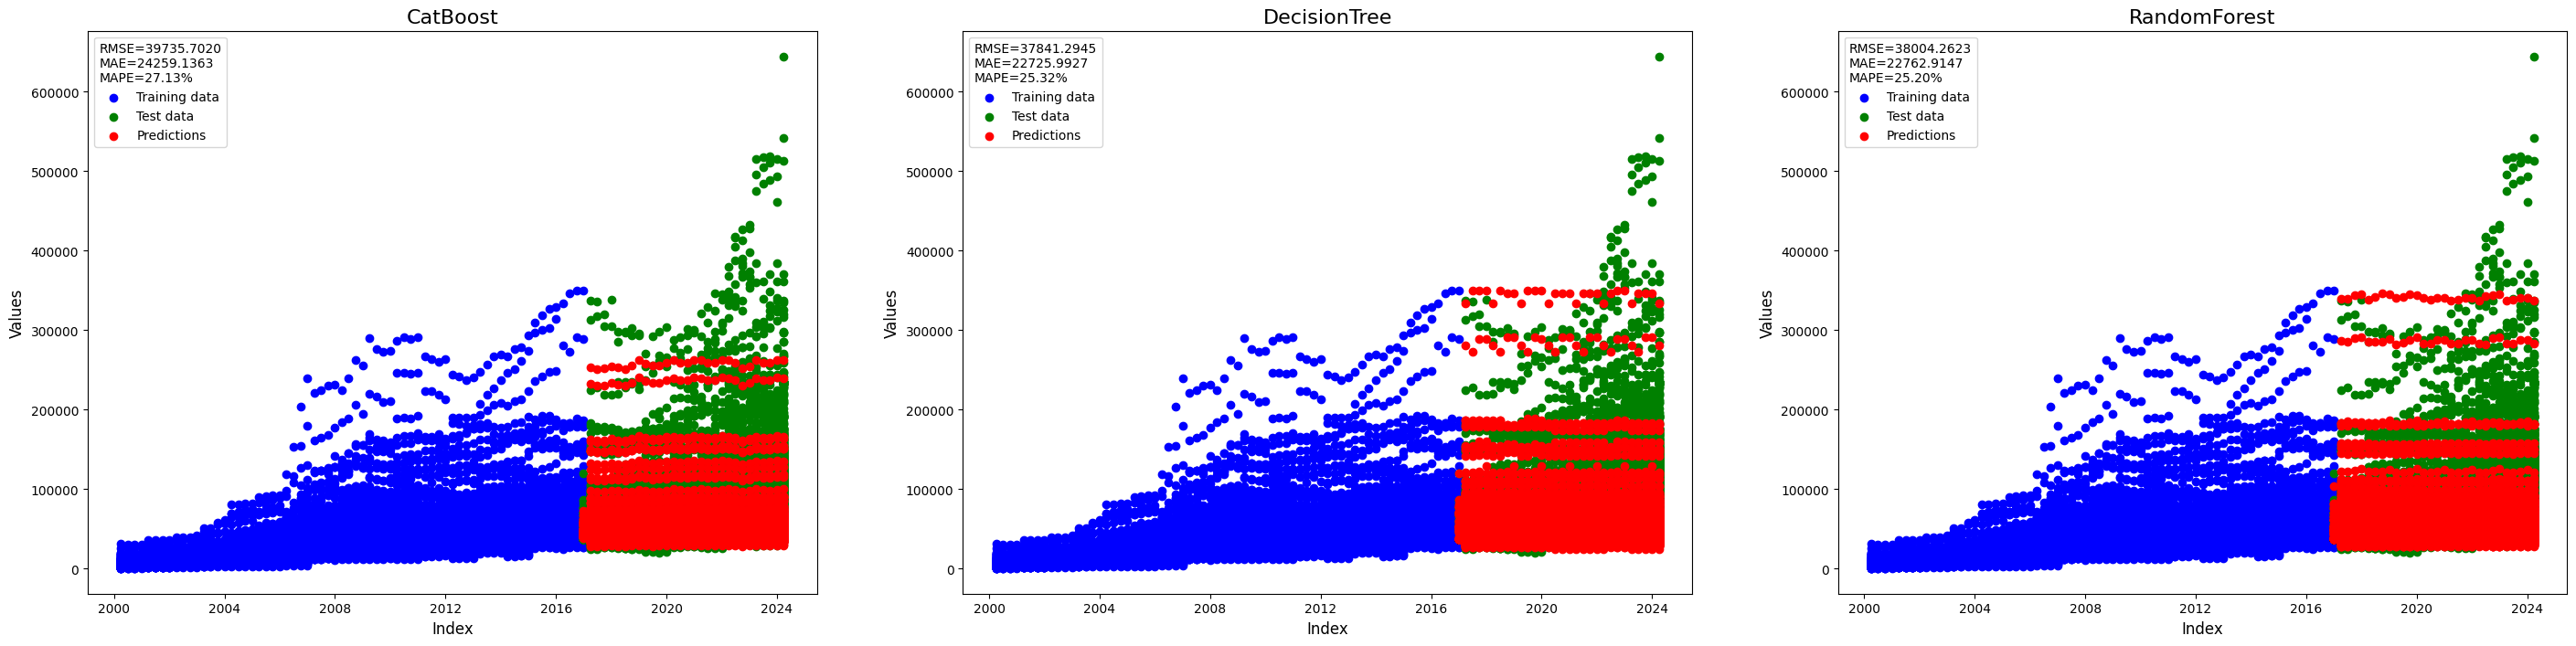

In [ ]:
draw_plot_show_metrics(
    (cat_pred, 'CatBoost'),
    (clf_predict, 'DecisionTree'),
    (regr_predict, 'RandomForest')
)
